In [1]:
import os
import h5py
import seaborn as sns
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import csv
import gzip
import scipy.io

import scipy.sparse as sps
import matplotlib.pyplot as plt

from os.path import join
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import normalize

from scNCL.metrics import osr_evaluator
from scNCL.core import BuildscNCL
import scNCL.utils as utls

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

np.random.seed(1234)

sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.7.2 anndata==0.7.8 umap==0.5.1 numpy==1.18.2 scipy==1.4.1 pandas==1.1.5 scikit-learn==0.24.2 statsmodels==0.11.1 python-igraph==0.9.4 louvain==0.7.0


## experiment id

In [2]:
exp_id = 'HFA-subset-50k' + '-1601'  # dataset_name + timestamp

## loading data

In [3]:
data_root = '../data/HumanFetal_50k'

adata_atac = sc.read_h5ad(join(data_root, 'ATAC/adata_atac.h5ad'))
adata_rna = sc.read_h5ad(join(data_root, 'RNA/adata_rna_sampled.h5ad'))
adata_rna.obs['cell_type'] = adata_rna.obs.Main_cluster_name.values
adata_rna.obs['domain']  = 'RNA'
adata_atac.obs['domain'] = 'ATAC' 

meta_rna = adata_rna.obs.copy()
meta_atac = adata_atac.obs.copy()

meta = pd.concat([meta_rna, meta_atac], axis=0)

In [4]:
adata_rna, adata_atac

(AnnData object with n_obs × n_vars = 20000 × 22121
     obs: 'All_reads', 'Assay', 'Batch', 'Development_day', 'Exon_reads', 'Experiment_batch', 'Fetus_id', 'Intron_reads', 'Main_cluster_name', 'Main_cluster_umap_1', 'Main_cluster_umap_2', 'Organ', 'Organ_cell_lineage', 'RT_group', 'Sex', 'Size_Factor', 'batch', 'obs_names', 'sample', 'cell_type', 'domain'
     var: 'exon_intron', 'gene_id', 'gene_short_name', 'gene_type', 'index', 'var_names',
 AnnData object with n_obs × n_vars = 30000 × 22121
     obs: 'sample_name', 'donor_id', 'day_of_pregnancy', 'sex', 'tissue', 'batch', 'total', 'total_deduplicated', 'total_deduplicated_peaks', 'total_deduplicated_tss', 'frip', 'frit', 'x_chrom_window_counts', 'y_chrom_window_counts', 'autosome_window_counts', 'blacklist_fraction', 'seurat_clusters', 'tissue_umap_1', 'tissue_umap_2', 'cell_type', 'domain')

In [5]:
# low-dimension representations of raw scATAC-seq data
atac_raw_emb = np.load('../cache/HFA_subset_50k_atac_pca.npy')
atac_raw_emb.shape

(30000, 49)

In [6]:
# params dict of preprocessing 
ppd = {'binz': True, 
       'hvg_num':adata_atac.shape[1], 
       'lognorm':False, 
       'scale_per_batch':False,  
       'batch_label': 'domain',
       'type_label':  'cell_type',
       'knn': 10,
       'knn_by_tissue':True
       }  # default settings

#  outputs folder
output_dir = join(f'../outputs/{exp_id}')
os.makedirs(output_dir, exist_ok=True)

## model 

In [12]:
model = BuildscNCL(
                n_latent=64, bn=False, dr=0.2,   # HFA-subset-100k, 200k, or larger, set n_latent=128
                cont_w=1., cont_tau=0.4,
        )
    
model.preprocess(
                [adata_rna, adata_atac],   # list of 'anndata' object
                atac_raw_emb,   
                adata_adt_inputs=None, 
                pp_dict = ppd
        )
    
if 1:
    # HFA-subset-100k = 12000
    # 200k = 18000
    # 400k = 24000
    # full = 30000
    model.train(
        batch_size=500, training_steps=6000,  
        lr=0.01, weight_decay=0,
        log_step=200, eval_atac=False, #eval_top_k=1, eval_open=True,  
    )
else:
    # loading checkpoints
    ckpt_path = join(output_dir, 'ckpt_6000.pth')
    model.load_ckpt(ckpt_path)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Finding highly variable genes...


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


knn correct ratio = 0.9727
step 0, loss_cls=4.005, loss_l1_reg=0.012, center=(0.007, 0.015), corr=(0.000, 0.000), var=(1.525, 0.725), loss_cont=6.901, loss_align=0.000
step 200, loss_cls=0.826, loss_l1_reg=0.016, center=(0.079, 0.073), corr=(0.016, 0.013), var=(0.132, 0.137), loss_cont=5.309, loss_align=0.000
step 400, loss_cls=0.371, loss_l1_reg=0.015, center=(0.080, 0.087), corr=(0.014, 0.018), var=(0.128, 0.115), loss_cont=5.277, loss_align=0.000
step 600, loss_cls=0.225, loss_l1_reg=0.015, center=(0.081, 0.090), corr=(0.013, 0.018), var=(0.125, 0.112), loss_cont=5.258, loss_align=0.000
step 800, loss_cls=0.161, loss_l1_reg=0.016, center=(0.078, 0.090), corr=(0.012, 0.017), var=(0.129, 0.111), loss_cont=5.214, loss_align=0.000
step 1000, loss_cls=0.111, loss_l1_reg=0.016, center=(0.078, 0.092), corr=(0.010, 0.017), var=(0.128, 0.109), loss_cont=5.168, loss_align=0.000
step 1200, loss_cls=0.106, loss_l1_reg=0.017, center=(0.073, 0.097), corr=(0.008, 0.019), var=(0.138, 0.103), loss_c

In [17]:
model.eval(inplace=True)
atac_pred_type = model.annotate()

# Evaluation

In [14]:
share_mask = meta_atac.cell_type.isin(meta_rna.cell_type.unique()).to_numpy()
open_score = 1 - np.max(model.head_B, axis=1) # pb_max, logit_max_B

kn_data_pr = atac_pred_type[share_mask]
kn_data_gt = meta_atac.cell_type[share_mask].to_numpy()
kn_data_open_score = open_score[share_mask]

unk_data_open_score = open_score[np.logical_not(share_mask)]

closed_acc, os_auroc, os_aupr, oscr = osr_evaluator(kn_data_pr, kn_data_gt, kn_data_open_score, unk_data_open_score)

close_acc= 0.8497


<AxesSubplot:>

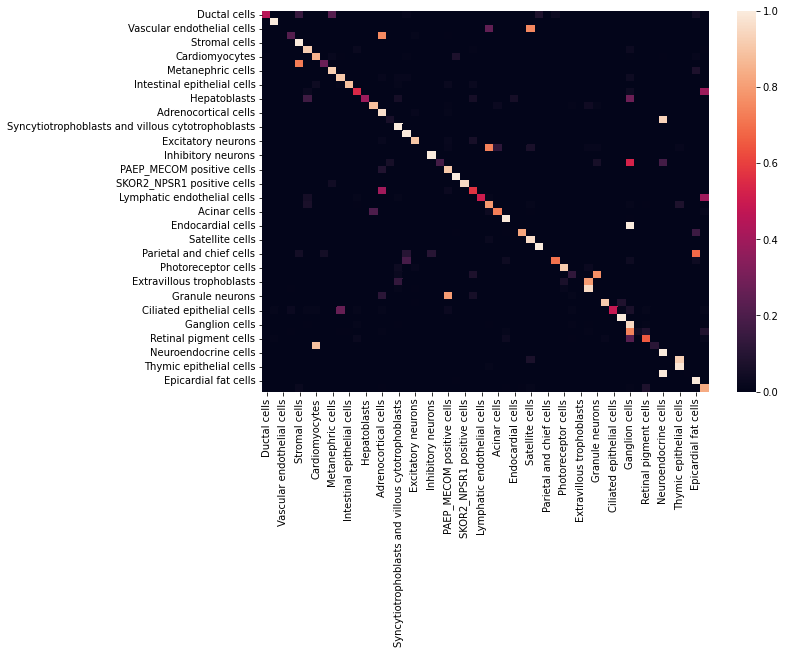

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(meta_atac.cell_type.to_numpy(), atac_pred_type)
cm = cm/cm.sum(axis=1, keepdims=True)

df_cm = pd.DataFrame(cm, index = meta_atac.cell_type.unique(),
                  columns = meta_atac.cell_type.unique())

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, )